In [1]:
# Imports
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset, Dataset, DatasetDict
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
import csv
import os
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

c:\Users\gianl\Documents\Code\uncertainty-aware-ship-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Parameters and Constants
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

TARGET_SIZE = (224, 224)
DATASET_NAME = "jbourcier/fgsc23"
DUPLICATION_THRESHOLD = 0.95

In [3]:
# Load Dataset
ds: Dataset = load_dataset(DATASET_NAME, split="train")

# Display Dataset Information
print(ds)

Dataset({
    features: ['image', 'label'],
    num_rows: 4080
})


In [4]:
# Mapping integer labels (0–22) to human-readable ship class names from Zhang et al. (2020)
label_map = {
    0:  "Non-ship",
    1:  "Aircraft carrier",
    12:  "Destroyer",
    16:  "Landing craft",
    17:  "Frigate",
    18:  "Amphibious transport dock",
    19:  "Cruiser",
    20:  "Tarawa-class amphibious assault ship",
    21:  "Amphibious assault ship",
    22:  "Command ship",
    2: "Submarine",
    3: "Medical ship",
    4: "Combat boat",
    5: "Auxiliary ship",
    6: "Container ship",
    7: "Car carrier",
    8: "Hovercraft",
    9: "Bulk carrier",
    10: "Oil tanker",
    11: "Fishing boat",
    13: "Passenger ship",
    14: "Liquefied gas ship",
    15: "Barge"
}

# Add a new column 'class_name' to the dataset with human-readable labels
def map_label(example):
    example['class_name'] = label_map.get(example['label'], "Unknown")
    return example

ds = ds.map(map_label)

# Display Dataset Information
print(ds)

Dataset({
    features: ['image', 'label', 'class_name'],
    num_rows: 4080
})


Class distribution (sorted):
class_name
Destroyer                               542
Non-ship                                484
Bulk carrier                            343
Frigate                                 295
Cruiser                                 293
Submarine                               238
Auxiliary ship                          225
Aircraft carrier                        166
Oil tanker                              165
Amphibious assault ship                 154
Combat boat                             143
Hovercraft                              120
Landing craft                           108
Fishing boat                            102
Container ship                          100
Liquefied gas ship                       94
Amphibious transport dock                90
Command ship                             89
Tarawa-class amphibious assault ship     88
Passenger ship                           88
Car carrier                              72
Barge                               

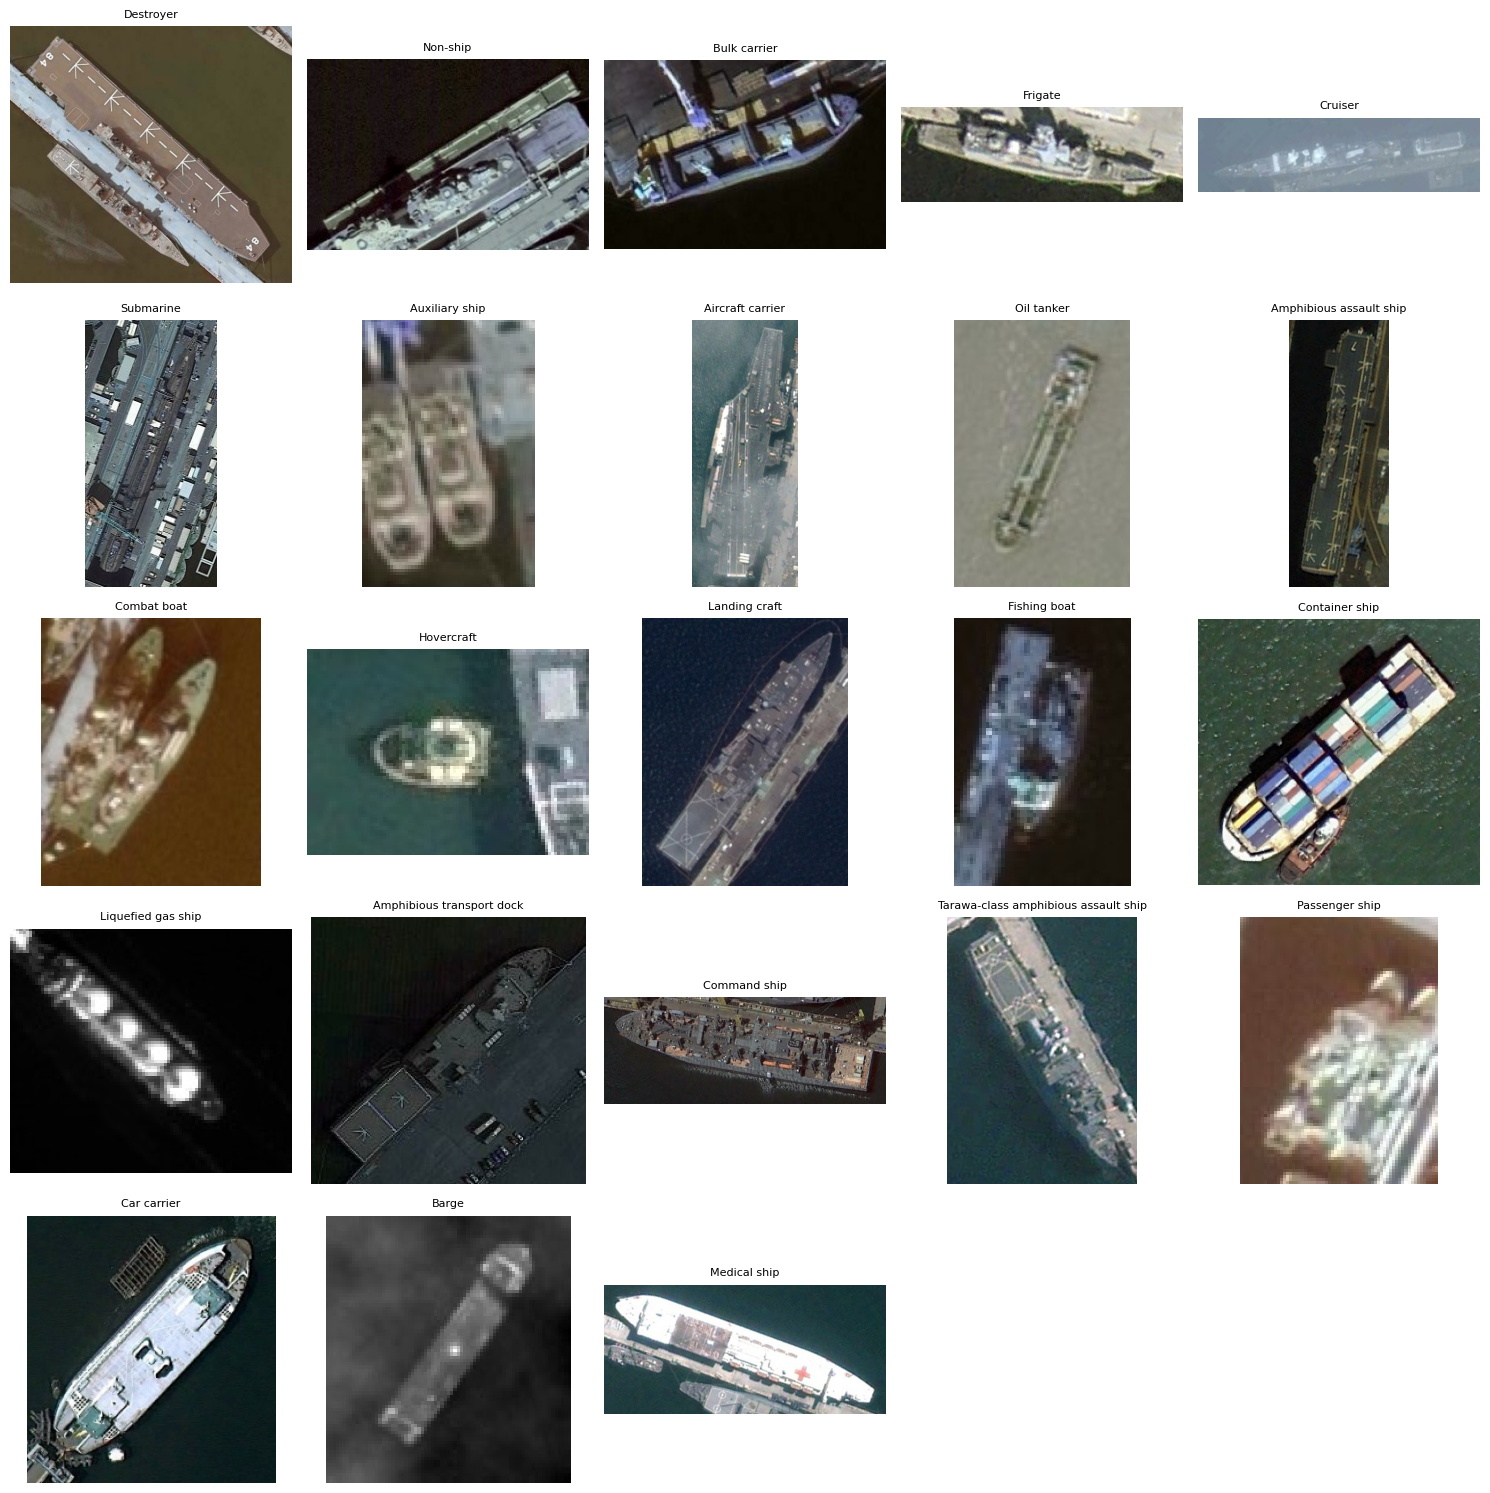

In [5]:
# Inspect Dataset

# Print class distribution sorted by sample count
class_counts = ds.to_pandas()['class_name'].value_counts().sort_values(ascending=False)
print("Class distribution (sorted):")
print(class_counts)

# Plot one image per class with label in a 5x5 grid (for 23 classes)
n_classes = len(class_counts)
n_rows, n_cols = 5, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

for i, class_name in enumerate(class_counts.index):
    row, col = divmod(i, n_cols)
    ax = axes[row, col]
    idx = int(ds.to_pandas().query("class_name == @class_name").index[0])
    img = ds[idx]['image']
    ax.imshow(img)
    ax.set_title(class_name, fontsize=8)
    ax.axis('off')

# Hide unused subplots if any
for j in range(n_classes, n_rows * n_cols):
    row, col = divmod(j, n_cols)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Deduplication of Near‑Identical Samples

# 1. Prepare transform + MobileNet backbone
transform = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485, .456, .406],
                         std=[.229, .224, .225]),
])

mobilenet = models.mobilenet_v3_large(
    weights=models.MobileNet_V3_Large_Weights.DEFAULT
)
backbone = torch.nn.Sequential(
    mobilenet.features,
    mobilenet.avgpool
).eval()

# 2. Iterate once to collect embeddings for RGB images
N = len(ds)

# infer embedding dimension
with torch.no_grad():
    dummy = torch.zeros(1, 3, *TARGET_SIZE)
    emb_dim = backbone(dummy).view(1, -1).shape[1]

# Preallocate with max possible size, will trim later
embeddings = torch.zeros((N, emb_dim), dtype=torch.float32)
labels     = np.zeros(N, dtype=int)
rgb_indices = []  # map from row→original idx in ds
row = 0

for idx in tqdm(range(N), desc="Computing embeddings"):
    img = ds[idx]["image"]
    if img.mode != "RGB":
        continue

    label = ds[idx]["label"]
    img_t = transform(img).unsqueeze(0)
    with torch.no_grad():
        feat = backbone(img_t).view(1, -1)
        feat = torch.nn.functional.normalize(feat, dim=1)

    embeddings[row] = feat
    labels[row]     = label
    rgb_indices.append(idx)
    row += 1

# trim to actual size
embeddings = embeddings[:row]
labels     = labels[:row]

# 3. Find near‐duplicate pairs within each class
to_remove = set()

for cls in np.unique(labels):
    cls_pos = np.where(labels == cls)[0]
    E = embeddings[cls_pos]
    sims = E @ E.T  # cosine similarities
    n = sims.shape[0]

    for i in range(n):
        for j in range(i+1, n):
            if sims[i, j] > DUPLICATION_THRESHOLD:
                # drop the *later* one j
                drop_idx = rgb_indices[cls_pos[j]]
                to_remove.add(drop_idx)

print(f"Dropping {len(to_remove)} near‐duplicates from dataset")

# 4. Filter out those indices from ds
ds = ds.filter(
    lambda _, idx: idx not in to_remove,
    with_indices=True
)

# 5. Save cleaned dataset back to disk
ds.save_to_disk("data/fgsc23_cleaned/")

# 6. Save removed indices to CSV
removed_indices_df = pd.DataFrame({'removed_idx': sorted(to_remove)})
removed_indices_path = os.path.join("data/fgsc23_cleaned/", "removed_indices.csv")
removed_indices_df.to_csv(removed_indices_path, index=False)

Computing embeddings: 100%|██████████| 4080/4080 [05:24<00:00, 12.57it/s]


Dropping 81 near‐duplicates from dataset


Saving the dataset (1/1 shards): 100%|██████████| 3999/3999 [01:48<00:00, 36.97 examples/s]


In [ ]:
# Apply Distortions, Resizing, and Padding

def resize_pad_blur(example):
    # get PIL image and make sure it's RGB
    img = example["image"].convert("RGB")
    
    # compute new size, preserving aspect ratio
    w, h = img.size
    scale = min(448 / w, 448 / h)
    new_w, new_h = int(w * scale), int(h * scale)
    img_resized = img.resize((new_w, new_h), Image.BILINEAR)
    
    # pad to 448×448 (black background)
    canvas = Image.new("RGB", (448, 448), (0, 0, 0))
    paste_x = (448 - new_w) // 2
    paste_y = (448 - new_h) // 2
    canvas.paste(img_resized, (paste_x, paste_y))
    
    # add a bit of random Gaussian blur
    radius = random.uniform(0.0, 2.0)  # you can tweak this range
    img_out = canvas.filter(ImageFilter.GaussianBlur(radius))
    
    # overwrite the "image" field in-place; keep all other columns
    example["image"] = img_out
    return example

In [ ]:
# Save the Dataset to Disk

In [ ]:
# Get Quality Scores using OpenAI API

In [ ]:
# Inspect Quality Scores

In [ ]:
# Save Quality Scores to Disk

In [ ]:
# Split Dataset into Train, Validation, and Test Sets and Save to Disk

In [ ]:
# DataLoaders and Batch Size etc.

In [ ]:
# Train and Evaluate Models without Regularization (ResNet18, MobileNetV3, EfficientNetB0) and Save Results and Model to Disk

In [ ]:
# Inspect Results with Regularization

In [ ]:
# Train and Evaluate Models with Regularization (ResNet18, MobileNetV3, EfficientNetB0) and Save Results and Model to Disk
# Inspect Results with Regularization
# Train and Evaluate Regressor for Quality Scores and Save Results and Model to Disk
# Inspect Results of Regressor for Quality Scores
# Global Conformal Prediction
# Our Conformal Prediction Quality-Bucket-Based Method

In [ ]:
# Ablation Studies Combinations:
# - ResNet18, MobileNetV3, EfficientNetB0
# - Regularization/Quality Scores: With, Without
# - Conformal Prediction: Global, Quality-Bucket-Based